In [1]:
%aiida

Loaded AiiDA DB environment.

In [2]:
import os
import numpy as np

from ipywidgets import interact

In [3]:
from aiida.orm import Code, DataFactory, CalculationFactory
from aiida.orm.data.base import Float, Str

SiestaCalculation = CalculationFactory('siesta.siesta')
PsfData = DataFactory('siesta.psf')
StructureData = DataFactory('structure')
ParameterData = DataFactory('parameter')
KpointsData = DataFactory('array.kpoints')

In [4]:
code = None
def select_code(codename):
    global code
    code = Code.get_from_string(codename)

code_choice = interact(select_code, 
                       codename=Code.list_for_plugin('siesta.siesta'))

interactive(children=(Dropdown(description=u'codename', options=(u'siesta-m',), value=u'siesta-m'), Output()), _dom_classes=('widget-interact',))

In [5]:
filter_elements=("Mg", "O")

In [6]:
pseudo_family = None
def select_pseudo_family(family):
    global pseudo_family
    pseudo_family = family
    
pseudo_family_choice = interact(select_pseudo_family,
                                family=PsfData.get_psf_groups(filter_elements=filter_elements))

interactive(children=(Dropdown(description=u'family', options=(<Group: "another_family" [type data.psf.family], of user vladimir.dikan@icn2.cat>, <Group: "example_family" [type data.psf.family], of user vladimir.dikan@icn2.cat>), value=<Group: "another_family" [type data.psf.family], of user vladimir.dikan@icn2.cat>), Output()), _dom_classes=('widget-interact',))

In [7]:
inputs = SiestaCalculation.process().get_inputs_template()
inputs.code = code
inputs._options.resources = {
    "num_machines": 1,
    "num_mpiprocs_per_machine": 1,
}
inputs._options.max_wallclock_seconds = 30 * 60

In [8]:
def create_FCC_structure(alat):
    lvecs = np.array([ 1.0,
                       1.0,
                       1.0,]) * alat
                   
    cell = np.array([[0.0, 0.5, 0.5,],
                     [0.5, 0.0, 0.5,],
                     [0.5, 0.5, 0.0,],])

    return np.multiply(cell, lvecs)

In [9]:
# Define MgO structure
alat = 4.117  # MgO lattice constant, Angstroms
cell = create_FCC_structure(alat)    # Creating MgO FCC-cell
structure = StructureData(cell=cell)  # Creating structure from cell 
# Placing basis atoms
structure.append_atom(
    position=(0.000 * alat, 0.000 * alat, 0.000 * alat),
    symbols=['Mg'])
structure.append_atom(
    position=(0.500 * alat, 0.500 * alat, 0.500 * alat),
    symbols=['O'])                    

inputs.structure = structure

In [10]:
# Pseudopotentials
from aiida_siesta.data.psf import get_pseudos_from_structure

inputs.pseudo = get_pseudos_from_structure(structure, pseudo_family.name)

In [11]:
# K-points mesh
kpoints_mesh = KpointsData()
kpoints_mesh.set_kpoints_mesh([6, 6, 6], [0.5, 0.5, 0.5])

inputs.kpoints = kpoints_mesh

In [12]:
# Bands' k-points
bandskpoints = KpointsData()
bandskpoints.set_cell(structure.cell, structure.pbc)
bandskpoints.set_kpoints_path([
    ('K', 'G', 39),
    ('G', 'X', 37),
    ('X', 'W', 19),
    ('W', 'L', 27),
    ('L', 'G', 32),
])

inputs.bandskpoints = bandskpoints

In [13]:
# Calculation parameters
parameters  = ParameterData(dict={
    'xc-functional': 'LDA',
    'xc-authors': 'CA',
    'spin-polarized': False,
    'meshcutoff': '200 Ry',
    'max-scfiterations': 50,
})

inputs.parameters = parameters

In [14]:
! verdi daemon restart

Shutting down AiiDA Daemon (1359)...
Waiting for the AiiDA Daemon to shut down...
AiiDA Daemon shut down correctly.
Clearing all locks ...
Starting AiiDA Daemon ...
Daemon started


In [15]:
# Create and run Siesta calculation process
from aiida.work.run import run

JobCalc = SiestaCalculation.process()
result = run(JobCalc, **inputs)

In [16]:
out     = result['output_parameters'].get_dict()
bands   = result['bands_array']
bparams = result['bands_parameters'].get_dict()

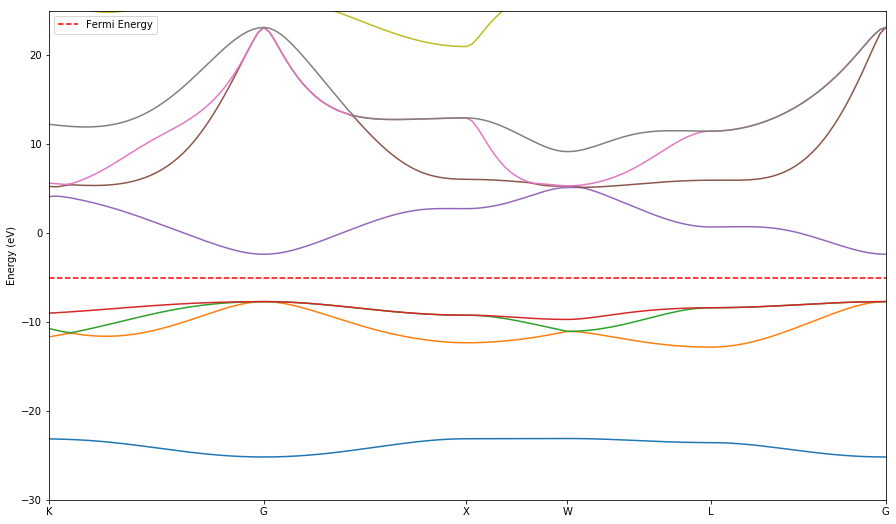

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15.0, 9.0)

# Plot bands
for band in zip(*bands.get_bands()):
    plt.plot(bparams['kp_coordinates'], band,)

# Plot E_Fermi
plt.plot((bparams['kp_coordinates'][0], bparams['kp_coordinates'][-1]),
         (out['E_Fermi'], out['E_Fermi']),
         '--r', label="Fermi Energy")   

ticks = [(bparams['kp_coordinates'][xt], xl) 
         for xt, xl in bandskpoints.labels]
plt.xticks(zip(*ticks)[0], zip(*ticks)[1])

plt.axis([0.0, 3.34, -30.0, 25.0])  # rescale
plt.ylabel("Energy (eV)")
plt.legend()

plt.show()